In [1]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import KMeans
from scalablexplain.imm.spark_cluster import DistributedIMMExplainer

## 1. Train Demo Model

In [2]:
JAR_PATH = "jars/spark-dimm-assembly.jar"
IRIS_CSV = "data/iris.csv"

### Note : During Spark Session initialization the distributed imm jar file needs to be added.

In [3]:
spark = SparkSession.builder \
    .appName("Test DIMM on Iris") \
    .config("spark.jars", JAR_PATH) \
    .getOrCreate()
spark.sparkContext.setLogLevel("ERROR")

25/08/13 05:49:53 WARN Utils: Your hostname, inuka-ampavila-HP-EliteBook-850-G7-Notebook-PC resolves to a loopback address: 127.0.1.1; using 192.168.1.7 instead (on interface wlp0s20f3)
25/08/13 05:49:53 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
25/08/13 05:49:53 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [6]:
K = 4
FEATURE_COLS = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']

# ---- Load Data ----
iris_df = spark.read.csv(IRIS_CSV, header=True, inferSchema=True)

# ---- Vectorize Features ----
vec_assembler = VectorAssembler(inputCols=FEATURE_COLS, outputCol="features")
df = vec_assembler.transform(iris_df)

# ---- KMeans Clustering ----
kmeans = KMeans(k=K, seed=42, featuresCol="features", predictionCol="prediction")
model = kmeans.fit(df)
clustered_df = model.transform(df)

In [7]:
print("\n=== Cluster Centers ===")
for i, center in enumerate(model.clusterCenters()):
    print(f"Cluster {i}: {center}")


=== Cluster Centers ===
Cluster 0: [5.53214286 2.63571429 3.96071429 1.22857143]
Cluster 1: [5.006 3.428 1.462 0.246]
Cluster 2: [6.27391304 2.88695652 4.89347826 1.68043478]
Cluster 3: [7.02692308 3.1        5.94615385 2.15      ]


## 2. Generate Distributed iterative Mistake Minimization Results

In [8]:
explainer = DistributedIMMExplainer(model, num_splits=16, max_bins=16, seed=42)
tree, splits, tree_str = explainer.explain(clustered_df)

Max Bins = 16 || 16
=== Best Split Decisions Per Node ===
Node 0: featureIndex=3, threshold=6.0, mistakes=0
=== Best Split Decisions Per Node ===
Node 2: featureIndex=2, threshold=16.0, mistakes=5
=== Best Split Decisions Per Node ===
Node 5: featureIndex=0, threshold=9.0, mistakes=8
=== Best Split Decisions Per Node ===
No more splittable nodes.


### Note: Currently debug messages include the threshold index used to split. it is not the exact value. How ever the final result can be observed using graphs or printing the tree as a dot file.

In [9]:
# ---- Output Tree ----
explainer.print_tree(tree_str)


=== IMM Tree ===
=== Final IMM Explanation Tree ===
Node 0: Node 0 | depth=0 | split=(f3 <= 0.800) | clusters=[0,1,3,2] | samples=150 | mistakes=0
Node 1: Leaf | depth=1 | split=No split | clusters=[1] | samples=50 | mistakes=0
Node 2: Node 2 | depth=1 | split=(f2 <= 5.550) | clusters=[0,3,2] | samples=100 | mistakes=0
Node 5: Node 5 | depth=2 | split=(f0 <= 5.750) | clusters=[0,2] | samples=72 | mistakes=0
Node 6: Leaf | depth=2 | split=No split | clusters=[3] | samples=25 | mistakes=2
Node 11: Leaf | depth=3 | split=No split | clusters=[0] | samples=24 | mistakes=2
Node 12: Leaf | depth=3 | split=No split | clusters=[2] | samples=51 | mistakes=9




DOT file exported to: results/imm_tree.dot


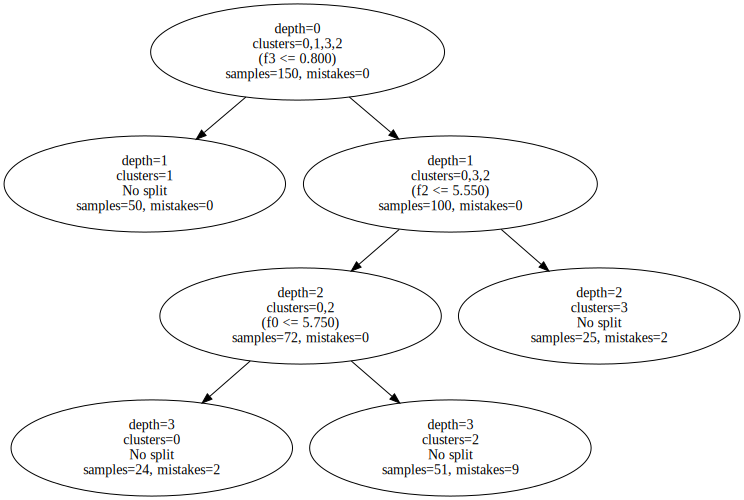

In [15]:
DOT_OUTPUT = "results/imm_tree.dot"

# ---- Optional: Export .dot for Graphviz ----
explainer.export_graphviz(tree_str, DOT_OUTPUT)
print(f"\nDOT file exported to: {DOT_OUTPUT}")

# ---- Stop Spark ----
spark.stop()

from graphviz import Source
from IPython.display import display

# Load and display inline
src = Source.from_file(DOT_OUTPUT)
display(src)  

'imm_tree.png'

Opening in existing browser session.
